# Aplicaciones de Aprendizaje Automático sobre Spotify 

## Propósito del documento

El objetivo del documento es explicar la aplicación de diferentes técnicas de aprendizaje automático sobre el dataset de [Spotify Tracks DB](https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db). El objetivo del proyecto será estudiar diferentes configuraciones de las técnicas  para determinar la popularidad que tendrá una canción.

## Descripción del Dataset

El dataset tiene un tamaño de 32,15 MB, contiene 232,725 pistas de música. Los datos para cada una de las pistas de música son los siguientes:
- **Genre**: Género (Película, Jazz, Reggaeton...)
- **artist_name**: Nombre del artista
- **track_name**: Nombre de la pista
- **track_id**: El id de Spotify para la pista.
- **Popularity**: Ínidice de popularidad de una pista (0- 100)
- **Acousticness**: Una medida de confianza de 0.0 a 1.0 de si la pista es acústica. 1,0 representa una alta confianza de que la pista es acústica.
- **Danceability**: describe lo adecuado que es un tema para el baile basado en una combinación de elementos musicales como el tempo, la estabilidad del ritmo, la fuerza del compás y la regularidad general. Un valor de 0.0 es el menos bailable y 1.0 es el más bailable. 
- **Duration_ms**: La duración de la pista en milisegundos.  
- **Energy**: La energía es una medida de 0,0 a 1,0 y representa una medida perceptiva de la intensidad y la actividad. Típicamente, las huellas de energía se sienten rápidas, fuertes y ruidosas.
- **Instrumentalness**: Predice si una pista no contiene voces. Los sonidos "Ooh" y "aah" son tratados como instrumentales en este contexto. Las pistas de rap o de palabra hablada son claramente "vocales". 
- **Key**: La clave general estimada de la pista. Los números enteros se asignan a los lanzamientos usando la notación estándar de la clase de lanzamiento. Por ejemplo, 0 = C, 1 = C♯/D♭, 2 = D, y así sucesivamente. Si no se detectó ninguna clave, el valor es -1.
- **Liveness**: Detecta la presencia de una audiencia en la grabación ( 1 música en concierto)
- **Loudness**: La sonoridad global de una pista en decibelios (dB)
- **Mode**: El modo indica la modalidad (mayor o menor) de una pista, el tipo de escala de la que se deriva su contenido melódico. La mayor se representa por 1 y la menor por 0. 
- **Speechiness**:  detecta la presencia de palabras habladas en una pista
- **Tempo**: El tempo global estimado de una pista en pulsaciones por minuto (BPM). En la terminología musical, el tempo es la velocidad o el ritmo de una pieza dada y se deriva directamente de la duración media del tiempo
- **Time_signature**: Una firma de tiempo global estimada de una pista. La signatura de tiempo (metro) es una convención notacional para especificar cuántos latidos hay en cada barra (o medida).
- **Valence**: Una medida de 0.0 a 1.0 que describe la positividad musical transmitida por una pista (1 muy positivo)

## Librerías

In [1]:
!pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in c:\users\manu_\anaconda3\lib\site-packages (2.2.2)


In [2]:
import pandas as pd
import numpy as np
from numpy import argmax
from sklearn.preprocessing import LabelBinarizer
import numpy.ma as ma
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from numpy import inf
from pandas.io.parsers import read_csv
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

###########################
####     OUR CLASES     ###
###########################
from LogisticRegression import OurLogisticRegression

## Lectura de Datos

In [3]:
data = pd.read_csv("data/SpotifyFeatures.csv")

In [4]:
data.shape

(232725, 18)

In [5]:
data.head(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


### Selección de variables dependientes ( x<sub>1 </sub>... x<sub>n </sub>) y Variable objetivo (y)

Las variables dependientes serán:
- acousticness
- danceability
- duration_ms
- energy
- instrumentalness
- key
- liveness 
- mode
- speechiness
- tempo
- time_signature
- valence
- genre

La variable objetivo será la popularidad de la canción

In [6]:
features = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'mode',
       'speechiness', 'tempo', 'valence', 'A', 'A#', 'B',
       'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A Capella',
       'Alternative', 'Anime', 'Blues', "Children's Music",
       'Classical', 'Comedy', 'Country', 'Dance', 'Electronic', 'Folk',
       'Hip-Hop', 'Indie', 'Jazz', 'Movie', 'Opera', 'Pop', 'R&B', 'Rap',
       'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul', 'Soundtrack', 'World']
target = 'popularity'
target_classified = 'popularity_class'

## Preprocesamiento

Antes de la elaboración de los modelos y las prueba de los mismos con diferentes configuraciones, debemos realizar un preoprocesado de los datos, en aquellas columnas que han sido seleccionadas para pertencer a los ejemplos de entrenamiento y no son númericas

#### Columna mode

Primero comprobaremos los diferentesvalores que tiene la columna

In [7]:
data['mode'].unique()

array(['Major', 'Minor'], dtype=object)

Como podemos comprobar la columna solo tiene valores Minor & Major, por ello, se colocará un 0 cuando el valor de la celda sea Minor y un 1 cuando el valor de la celda sea Major.

In [8]:
data.loc[data['mode'] == 'Minor', 'mode'] = 0
data.loc[data['mode'] == 'Major', 'mode'] = 1
data.sample(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
205269,Soundtrack,John Debney,Peaceful But Primitive / Procession,0kLUHkrrTK4TmtbIOOuoCg,29,0.46200,0.172,216173,0.116,0.96000,C,0.110,-20.957,1,0.0391,114.353,5/4,0.0399
140932,Indie,Foreign Air,Everything Is Good Now,6DVLyw8MXDpyM6bm1UWZE3,45,0.13100,0.533,178680,0.720,0.00417,B,0.203,-5.485,1,0.0247,97.023,4/4,0.5980
145124,Indie,Tennyson,Lay-by,4l6Ni4ym9y3am94yvuKHcY,47,0.00671,0.313,271333,0.466,0.93300,A,0.427,-9.963,0,0.0341,175.563,3/4,0.1620
152339,R&B,Ella Mai,Naked - Bonus Track,0SbOpoBzBBCqWIcvo94JeD,73,0.78200,0.356,197183,0.388,0.00000,A,0.109,-8.532,1,0.0652,175.123,4/4,0.5730
75262,Children's Music,Radha,Hokey Tokey,0X2NarN0QYahyMvbBZjZZf,0,0.31100,0.614,373733,0.397,0.00000,C,0.434,-8.606,1,0.3890,72.237,4/4,0.5410


#### Columna key

Tras leer varios artículos, hemos aprendido que no es bueno que en columna con muchos posibles valores categóricos, transformarla en una columna solo con valores que representen al valor categórico, ya que los algunos modelos asignan mayor importancia a valores más altos, poor ello debemos creearnos columnas de tipo bool con nombres de los valores categóricos y poner un 1 si se trata de este valor categórico y cero en caso contrario, esta técnica se denomina OneHotEncoder. Procedemos a crearlas:

In [9]:
lb = LabelBinarizer()
data = data.join(pd.DataFrame(lb.fit_transform(data["key"]),columns=lb.classes_,index=data.index))

#### Columna Genre

In [10]:
lb = LabelBinarizer()
data = data.join(pd.DataFrame(lb.fit_transform(data["genre"]),columns=lb.classes_,index=data.index))

#### Generar variable objetivo multiclase

Previamente, dado que actuamente la variable popularidad es una variable continua deberemos discretizarla,para ello se crearán las siguientes clases:
- Alta (2): Popularidad > 70
- Popularidad Media (1) : 40 <= Popularidad <= 70
- Popularidad Baja (0): Popularidad < 40

In [11]:
def label (row):
    if row['popularity'] < 40  :
        return 0
    elif row['popularity'] > 70 :
        return 2
    return 1

In [12]:
data['popularity_class'] = data.apply (lambda row: label(row), axis=1)

### Selección conjunto entrenamiento, validación, test

A lo largo del proyecto se utilizarán tres conjuntos de datos para la realización de pruebas:
- **Entrenamiento**: 70% de las pistas de música
- **Validación**: 20% de las pistas de música
- **Test**: 10% de las pistas de música

In [13]:
data = data.sample(frac=1)

In [14]:
data.sample(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,R&B,Rap,Reggae,Reggaeton,Rock,Ska,Soul,Soundtrack,World,popularity_class
204072,Soundtrack,James Horner,"I See You (From ""Avatar"")",1I8oH6Bbh110fOOvuHGGEC,35,0.923000,0.176,280573,0.184,0.755,...,0,0,0,0,0,0,0,1,0,0
970,Country,Bottleneck,Off the Rails (feat. Upchurch),46EBSHECmtgkJUZZwTXebE,43,0.026300,0.739,192327,0.914,0.000,...,0,0,0,0,0,0,0,0,0,1
2969,Alternative,Three Days Grace,Gone Forever,2Xe2YAxNPqWCNpZ8RagBdO,57,0.017500,0.409,221093,0.761,0.000,...,0,0,0,0,0,0,0,0,0,1
187782,Ska,Strung Out,Never Speak Again,6FFkdcbOojABjexNBuIlk8,25,0.000037,0.239,241627,0.947,0.772,...,0,0,0,0,0,1,0,0,0,0
163892,Reggaeton,Son Tentacion,Con la Misma Moneda,0XqXQR4GThOnJxbJ1MNYng,37,0.398000,0.697,258587,0.621,0.000,...,0,0,0,1,0,0,0,0,0,0


In [15]:
train = data[:int(data.shape[0] * 0.7)]
val = data[int(data.shape[0] * 0.7):int(data.shape[0] * 0.9)]
test = data[int(data.shape[0] * 0.9):]

In [16]:
print('La estructura del dataframe de Test es {}'.format(train.shape))
print('La estructura del dataframe de Test es {}'.format(val.shape))
print('La estructura del dataframe de Test es {}'.format(test.shape))

La estructura del dataframe de Test es (162907, 58)
La estructura del dataframe de Test es (46545, 58)
La estructura del dataframe de Test es (23273, 58)


## Regresión Lineal

- Separamos datos en entrenamiento, validación y test
- Normalizamos datos
- Averiguamos coste y thethas optimas (linearCostGrad y después optimize)
- ¿Se usa la funcion optimice de scipy (como en la practica 5 de Regresión Lineal Regularizada)? ¿O se hace todo con nuestro código como en la práctica 1?
- Pintamos error en datos de entrenamiento y de validación.
- Elegimos parámetro de regularización.
- Creamos modelo.


In [17]:
def cost(thetas, X, Y, reg=0):
    m = X.shape[0]
    H = np.dot(X, thetas)
    cost = (1/(2*m)) * np.sum((H-Y.T)**2) + ( reg / (2 * m) ) * np.sum(thetas[1:]**2)
    return cost

def gradient(thetas, X, Y, reg=0):
    tt = np.copy(thetas)
    tt[0]=0
    m = X.shape[0]
    H = np.dot(X, thetas)
    gradient = ((1 / m) * np.dot(H-Y.T,X)) + ((reg/m) * tt)
    return gradient

def linearCostGrad(thetas,X,Y,reg=0):
    return (cost(thetas,X,Y,reg),gradient(thetas,X,Y).flatten())

def polinomial_data(X,p):
    X_poly = X
    for i in range(1, p):
        X_poly = np.column_stack((X_poly, np.power(X, i+1)))   
    return X_poly

def normalize(X):
    medias = np.mean(X,axis=0)
    sigmas = np.std(X,axis=0)
    
    X_normalizada = (X - medias) / sigmas
    
    return (X_normalizada, medias, sigmas)

## Regresión Logística

Previamente, dado que actuamente la variable popularidad es una variable continua deberemos discretizarla,para ello se escogerá la columna 'popularity class' como variable objetivo donde:
- Alta (2): Popularidad > 70
- Popularidad Media (1) : 40 <= Popularidad <= 70
- Popularidad Baja (0): Popularidad < 40

In [25]:
X_train = np.array(train[features])
Y_train = np.array(train[target_classified])
X_val = np.array(val[features])
Y_val = np.array(val[target_classified])
X_test = np.array(test[features])
Y_test = np.array(test[target_classified])

#### Regresión Logística Implementada

In [26]:
log_reg = OurLogisticRegression(num_features=X_train.shape[1],num_labels=2)

In [27]:
log_reg.fit(X=X_train, Y=Y_train)

In [28]:
log_reg.score(Y_val,log_reg.predict(X_val))

82.75217531421205

En esta primera prueba hemos obtenido una precisión del 83%, para estudiar distintas configuraciones aplicaremos curvas de validación, con el objetivo de ver cual es el mejor hiperparámetro reg

Comprobamos como evoluciona la precisión en función del parámetro de regualrización:
    

El mejor parámetro de regularización es : 7


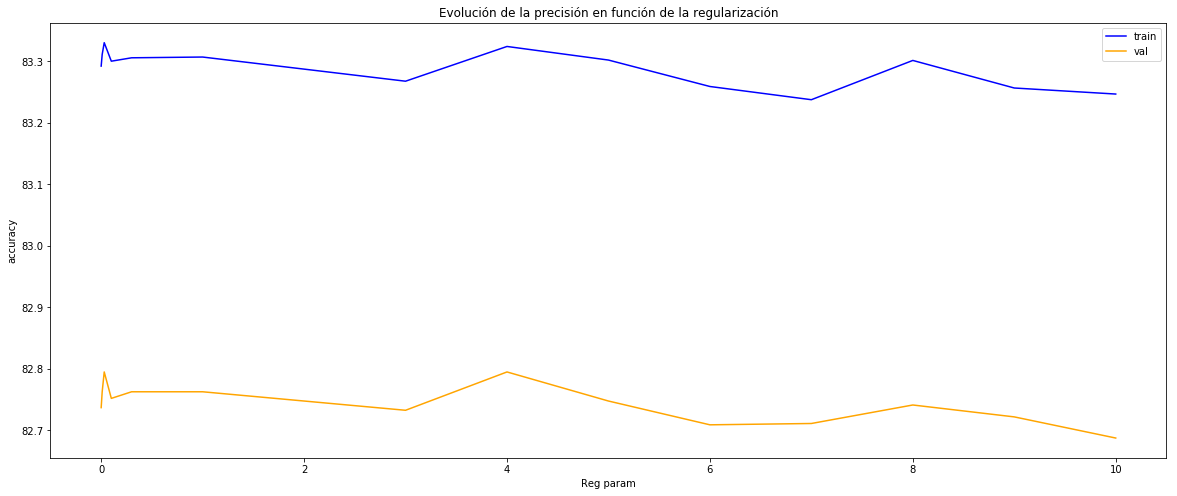

In [29]:
regs = [0, 0.01, 0.03, 0.1, 0.3, 1, 3,4,5,6,7,8,9,10]
acc_train_list = []
acc_val_list = []
best_reg = None
less_diff = inf
for reg in regs:
    log_reg = OurLogisticRegression(num_features=X_train.shape[1],num_labels=2,reg=reg)
    log_reg.fit(X=X_train, Y=Y_train)
    acc_train = log_reg.score(Y_train,log_reg.predict(X_train))
    acc_val = log_reg.score(Y_val,log_reg.predict(X_val))
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)
    if(less_diff > abs(acc_val-acc_train)):
        best_reg = reg
        less_diff = abs(acc_val-acc_train)
plt.figure(figsize=(20,8))
plt.plot(regs,acc_train_list, color="blue")
plt.plot(regs,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('Reg param')
plt.title("Evolución de la precisión en función de la regularización")
print("El mejor parámetro de regularización es : {}".format(best_reg))

Se ha escogido como parámetro de regularización 0, ya que no sufre Overfitting ni Underfitting, es decir, adquiere buen resultado con muestras nuevas una vez entrenado. Una vez seleccionado el parámetro de regularización procedemos a crear un modelo con dicho parámetro, entrarlo con los datos de entrenamiento y obtener resultado para el nuevo conjunto de datos de test.

In [30]:
log_reg = OurLogisticRegression(num_features=X_train.shape[1],num_labels=2,reg=0.1)
log_reg.fit(X=X_train, Y=Y_train)
print("La precisión del algoritmo implementado por los alumnos es: {}".format(log_reg.score(Y_test,log_reg.predict(X_test))))

La precisión del algoritmo implementado por los alumnos es: 83.10918231426976


Observamos que tras las curvas de validación se ha mejorado ligeramente la precisión del modelo

#### Regresión Logística Scikit-learn

En este apartado se realizarán pruebas sobre los diferentes modelos de optimización existentes en Regresión Logística en la librería de scikit-learn. Primero obtendremos el algoritmo con mayor número de porcentaje sobre los datos de validación y tras ello se aplicarán diferentes configuraciones, para finalmente realizar predicciones sobre el tercer conjunto de datos, Test.

In [31]:
models = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

In [32]:
for solver in models:
    if solver == "liblinear":
        model = LogisticRegression(solver=solver)
    else: 
        model = LogisticRegression(solver=solver, multi_class ="multinomial")
    model.fit(X=X_train, y=Y_train)
    print("La precisión con el algoritmo {} sobre los datos de validación es: {} % ".format(solver, model.score(X_val, Y_val) * 100))

La precisión con el algoritmo newton-cg sobre los datos de validación es: 82.69416693522398 % 
La precisión con el algoritmo lbfgs sobre los datos de validación es: 53.39349017080245 % 
La precisión con el algoritmo liblinear sobre los datos de validación es: 54.25502202169943 % 
La precisión con el algoritmo sag sobre los datos de validación es: 53.39349017080245 % 
La precisión con el algoritmo saga sobre los datos de validación es: 53.39349017080245 % 


Escogemos el algoritmo de optimización newton-cg y probamos diferentes configuraciones creando una curva de validación:

In [ ]:
C_params = [0.1, 0.5, 1 ,1.5, 2, 3, 5, 10]
acc_train_list = []
acc_val_list= []
best_param = None
best_acc = 0
for C in C_params:
    model = LogisticRegression(solver='newton-cg', multi_class ="multinomial", C=C)
    model.fit(X=X_train, y=Y_train)
    acc_train_list.append(log_reg.score(Y_train,model.predict(X_train)))
    acc_val_list.append(log_reg.score(Y_val,model.predict(X_val)))  

Text(0.5, 1.0, 'Evolución de la precisión en función del parámetro C')

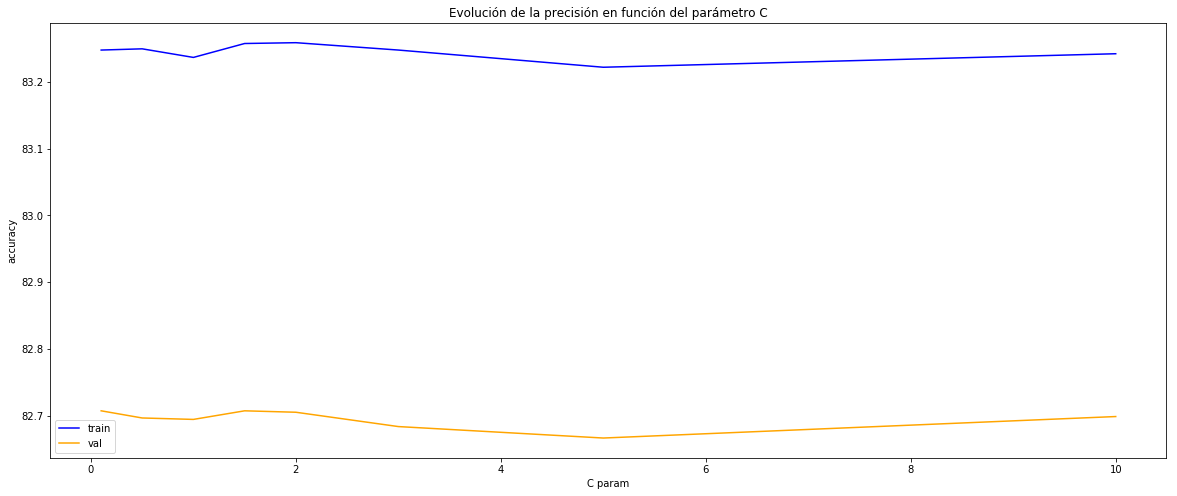

In [34]:
plt.figure(figsize=(20,8))
plt.plot(C_params,acc_train_list, color="blue")
plt.plot(C_params,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('C param')
plt.title("Evolución de la precisión en función del parámetro C")

Tras obtener la mejor configuración (C=1.5) ,la aplicamos al tercer conjunto de datos

In [35]:
model = LogisticRegression(solver='newton-cg', multi_class ="multinomial", C=1.5)
model.fit(X=X_train, y=Y_train)
print("La precisión del algoritmo implementado por la librería scikit-learn es: {}".format(log_reg.score(Y_test,log_reg.predict(X_test))))

La precisión del algoritmo implementado por la librería scikit-learn es: 83.10918231426976


Como conclusión a este apartado de Regresión Logística podemos afirmar que la mejor precisión obtenida tanto por la implementación realizada por los alumnos como la librería scikit learn, otorgan una precisión del 83,1%. Las curvas de validación realizadas varían muy poco, aún asi se ha escogido los mejores hiperparámetros para la realización del modelo.

## Redes Neuronales

## Máquinas de vector de soporte

Previamente, dado que actuamente la variable popularidad es una variable continua deberemos discretizarla,para ello se escogerá la columna 'popularity class' como variable objetivo donde:
- Alta (2): Popularidad > 70
- Popularidad Media (1) : 40 <= Popularidad <= 70
- Popularidad Baja (0): Popularidad < 40

Dado que esta técnica tiene un coste en tiempo muy elevado, antes de realizar curvas de validación se ha optado por añadir curvas de aprendizaje para conocer a partir de qué cantidad de datos no se adquiere una mejora sustancial del modelo.Se estudiará el comportamiento de dos algoritmos de optimización:

#### Kernel Lineal

Primero, realziamos una curva de aprendizaje para conocer a partir de qué número de ejemplos, dejamos de obtener una mejora sustancial en la precisión del modelo:

Text(0.5, 1.0, 'Evolución de la precisión')

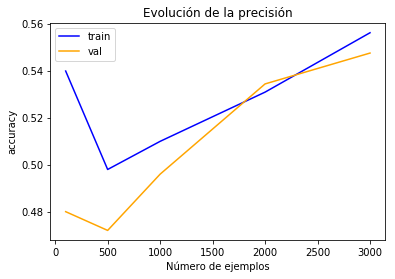

In [19]:
acc_train_list = []
acc_val_list = []
sizes = [100,500,1000,2000,3000]

for size in sizes:
    #Get new sets
    new_train = train[:size]
    new_val = val[:size]
    X_train = np.array(new_train[features])
    Y_train = np.array(new_train[target_classified])
    X_val = np.array(new_val[features])
    Y_val = np.array(new_val[target_classified])
    #Train with this size
    svm = SVC(kernel='linear', C=1)
    svm.fit(X_train, Y_train)
    #Get acc
    acc_train = accuracy_score(Y_train,svm.predict(X_train))
    acc_val = accuracy_score(Y_val,svm.predict(X_val))
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)
    
plt.plot(sizes,acc_train_list, color="blue")
plt.plot(sizes,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('Número de ejemplos')
plt.title("Evolución de la precisión")

Como podemos ver en la gráfica anterior, los valores no terminan de converger hacia un mismo punto, por loq ue probando con conjutnos mas grándes podamos obtener una mayor precisión, por tanto volvemos a realziar una curva de aprendizaje llegando a tamaños de con jutnos de datos mayores.

In [ ]:
acc_train_list = []
acc_val_list = []
sizes = [100,500,3000,10000]

for size in sizes:
    #Get new sets
    new_train = train[:size]
    new_val = val[:size]
    X_train = np.array(new_train[features])
    Y_train = np.array(new_train[target_classified])
    X_val = np.array(new_val[features])
    Y_val = np.array(new_val[target_classified])
    #Train with this size
    svm = SVC(kernel='linear', C=1)
    svm.fit(X_train, Y_train)
    #Get acc
    acc_train = accuracy_score(Y_train,svm.predict(X_train))
    acc_val = accuracy_score(Y_val,svm.predict(X_val))
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)
    
plt.plot(sizes,acc_train_list, color="blue")
plt.plot(sizes,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('Número de ejemplos')
plt.title("Evolución de la precisión")

Como podemos observar en la gráfica anterior, convergen los valores de train y de test en conjutnos de datos con un tamaño de X elementos por lo que quiere decir que añadir mayor número de datos no cambiará en gran medida la precisión del modelo. Por tanto a continuación se realizan cruvas de validación para conocer el mejor valor del hiperparámetro C.

In [20]:
new_train = train[:X_trainainainw_val = val[:]
X_train = np.array(new_train[features])
Y_train = np.array(new_train[target_classified])
X_val = np.array(new_val[features])
Y_val = np.array(new_val[target_classified])

In [ ]:
C_params = [0.01, 1, 10]
acc = []
acc_train_list = []
acc_val_list = []
best_reg = None
less_diff = inf
for C in C_params:
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_train, Y_train)
    acc_train = log_reg.score(Y_train,log_reg.predict(X_train))
    acc_val = log_reg.score(Y_val,log_reg.predict(X_val))
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)
    if(less_diff > abs(acc_val-acc_train)):
        best_reg = reg
        less_diff = abs(acc_val-acc_train)    
plt.plot(regs,acc_train_list, color="blue")
plt.plot(regs,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('C')
plt.title("Evolución de la precisión")
print("El mejor parámetro C es : {}".format(best_reg))

En la gráfica anterior podemos comprobar que el mejor parámetro es (C=X), una vez que hemos obtenido la mejor configuración procedemos a aplicarla en los datos de test

In [27]:
svm = SVC(kernel='linear', C=1)
svm.fit(X_train, Y_train)
print("La precisión obtenida por SVM con kernel lineal es; {}".format(accuracy_score(Y_train,svm.predict(X_train))))

NameError: name 'log_reg' is not defined

#### Kernel rbf

In [ ]:
acc_train_list = []
acc_val_list = []
sizes = [100,500,1000,2000,3000]

for size in sizes:
    #Get new sets
    new_train = train[:size]
    new_val = val[:size]
    X_train = np.array(new_train[features])
    Y_train = np.array(new_train[target_classified])
    X_val = np.array(new_val[features])
    Y_val = np.array(new_val[target_classified])
    #Train with this size
    svm = SVC(kernel='linear', C=1, sigma=0.1)
    svm.fit(X_train, Y_train)
    #Get acc
    acc_train = accuracy_score(Y_train,svm.predict(X_train))
    acc_val = accuracy_score(Y_val,svm.predict(X_val))
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)
    
plt.plot(sizes,acc_train_list, color="blue")
plt.plot(sizes,acc_val_list, color="orange")
plt.legend(['train', 'val'])
plt.ylabel('accuracy')
plt.xlabel('Número de ejemplos')
plt.title("Evolución de la precisión")

A continuación, crearemos una curva de validación, para comprobar cual es el mejor valor del hiperparámetro C y gama. Una vez obtenida la mejor configuración del hiperparametro C y gamma lo aplicaremos a los datos de Test.

In [ ]:
C_params = [0.01, 1, 10, 30]
gamma_params = np.logspace(-3, -1, 3)
acc_train_list = []
acc_val_list = []
index = 1
plt.subplots(3,3,figsize=(10,10))
for C in C_params:
    acc = []
    for gamma in gamma_params: 
        svm = SVC(kernel='rbf', C=C, gamma=gamma)
        svm.fit(X_train, Y_train)
        acc_train = log_reg.score(Y_train,log_reg.predict(X_train))
        acc_val = log_reg.score(Y_val,log_reg.predict(X_val))
        acc_train_list.append(acc_train)
        acc_val_list.append(acc_val)
    plt.subplot(3, 3, index)
    plt.tight_layout()
    plt.plot(regs,acc_train_list, color="blue")
    plt.plot(regs,acc_val_list, color="orange")
    plt.legend(['train', 'val'])
    plt.ylabel('accuracy')
    plt.xlabel('C')
    plt.title("Evolución de la precisión en función del parámetro C con gamma = {}".format(sigma))
    index +=1

En la gráficas anteriores podemos comprobar que el mejor parámetro es (C=X) y gamma = , una vez que hemos obtenido la mejor configuración procedemos a aplicarla en los datos de test

In [ ]:
svm = SVC(kernel='rbf', C=, gamma=)
svm.fit(X_train, Y_train)
print("La precisión obtenida por SVM con kernel lineal es; {}".format(log_reg.score(Y_train,log_reg.predict(X_train)))

## Conclusiones